In [ ]:
# default_exp models.nhits.nhits

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import math
import random
from functools import partial
from typing import Tuple, List
from fastcore.foundation import patch

import numpy as np
import pandas as pd
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pytorch_lightning as pl

from neuralforecast.models.components.tcn import _TemporalConvNet
from neuralforecast.models.components.common import Chomp1d, RepeatVector
from neuralforecast.losses.utils import LossFunction
from neuralforecast.data.tsdataset import WindowsDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [ ]:
#export
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)
    
    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

In [ ]:
#export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, interpolation_mode: str):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
 
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        if self.interpolation_mode=='nearest':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif self.interpolation_mode=='linear':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = len(backcast)
            knots = knots[:,None,None,:]
            forecast = t.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:]

        return backcast, forecast

In [ ]:
#export
class _ExogenousBasisInterpretable(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis = insample_x_t
        forecast_basis = outsample_x_t

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisWavenet(nn.Module):
    def __init__(self, out_features, in_features, num_levels=4, kernel_size=3, dropout_prob=0):
        super().__init__()
        # Shape of (1, in_features, 1) to broadcast over b and t
        self.weight = nn.Parameter(t.Tensor(1, in_features, 1), requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(0.5))

        padding = (kernel_size - 1) * (2**0)
        input_layer = [nn.Conv1d(in_channels=in_features, out_channels=out_features,
                                 kernel_size=kernel_size, padding=padding, dilation=2**0),
                                 Chomp1d(padding),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_prob)]
        conv_layers = []
        for i in range(1, num_levels):
            dilation = 2**i
            padding = (kernel_size - 1) * dilation
            conv_layers.append(nn.Conv1d(in_channels=out_features, out_channels=out_features,
                                         padding=padding, kernel_size=3, dilation=dilation))
            conv_layers.append(Chomp1d(padding))
            conv_layers.append(nn.ReLU())
        conv_layers = input_layer + conv_layers

        self.wavenet = nn.Sequential(*conv_layers)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = x_t * self.weight # Element-wise multiplication, broadcasted on b and t. Weights used in L1 regularization
        x_t = self.wavenet(x_t)[:]

        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisTCN(nn.Module):
    def __init__(self, out_features, in_features, num_levels = 4, kernel_size=2, dropout_prob=0):
        super().__init__()
        n_channels = num_levels * [out_features]
        self.tcn = _TemporalConvNet(num_inputs=in_features, num_channels=n_channels, kernel_size=kernel_size, dropout=dropout_prob)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = self.tcn(x_t)[:]
        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

In [ ]:
#export
def _init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

In [ ]:
#export
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class _NHITSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_mlp_units: list,
                 n_pool_kernel_size: int, pooling_mode: str, basis: nn.Module,
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation: str):
        """
        """
        super().__init__()

        assert (pooling_mode in ['max','average'])

        n_time_in_pooled = int(np.ceil(n_time_in/n_pool_kernel_size))

        if n_s == 0:
            n_s_hidden = 0
        n_mlp_units = [n_time_in_pooled + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_mlp_units
        
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.n_pool_kernel_size = n_pool_kernel_size
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        if pooling_mode == 'max':
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)
        elif pooling_mode == 'average':
            self.pooling_layer = nn.AvgPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_mlp_units[i], out_features=n_mlp_units[i+1]))
            hidden_layers.append(activ)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_mlp_units[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_mlp_units[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)
        
        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

In [ ]:
#export
class _NHITS(nn.Module):
    """
    NHITS Model.
    """
    def __init__(self, 
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 n_x_hidden,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_mlp_units: list,
                 n_pool_kernel_size: list,
                 n_freq_downsample: list,
                 pooling_mode,
                 interpolation_mode,
                 dropout_prob_theta,
                 activation,
                 initialization,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_x_hidden=n_x_hidden,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_mlp_units=n_mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   initialization=initialization)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, 
                     n_time_in, n_time_out, 
                     n_x, n_x_hidden, n_s, n_s_hidden, 
                     n_layers, n_mlp_units, 
                     n_pool_kernel_size, n_freq_downsample, pooling_mode, interpolation_mode,
                     batch_normalization, dropout_prob_theta, 
                     activation, shared_weights, initialization):                     
        block_list = []
        for i in range(len(stack_types)):
            assert stack_types[i] in ['identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'], 'f Invalid stack type {stack_types[i]}'
            for block_id in range(n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'identity':
                        n_theta = (n_time_in + max(n_time_out//n_freq_downsample[i], 1) )
                        basis = _IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out,
                                              interpolation_mode=interpolation_mode)                        

                    elif stack_types[i] == 'exogenous':
                        n_theta = 2 * n_x
                        basis = _ExogenousBasisInterpretable()

                    elif stack_types[i] == 'exogenous_tcn':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisTCN(n_x_hidden, n_x)

                    elif stack_types[i] == 'exogenous_wavenet':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisWavenet(n_x_hidden, n_x)

                    nbeats_block = _NHITSBlock(n_time_in=n_time_in,
                                               n_time_out=n_time_out,
                                               n_x=n_x,
                                               n_s=n_s,
                                               n_s_hidden=n_s_hidden,
                                               n_theta=n_theta,
                                               n_mlp_units=n_mlp_units[i],
                                               n_pool_kernel_size=n_pool_kernel_size[i],
                                               pooling_mode=pooling_mode,
                                               basis=basis,
                                               n_layers=n_layers[i],
                                               batch_normalization=batch_normalization_block,
                                               dropout_prob=dropout_prob_theta,
                                               activation=activation)

                # Select type of evaluation and apply it to all layers of block
                init_function = partial(_init_weights, initialization=initialization)                                             
                nbeats_block.layers.apply(init_function)
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                insample_mask: t.Tensor, outsample_mask: t.Tensor,
                return_decomposition: bool=False):
        
        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]
        insample_mask = insample_mask[:, :-self.n_time_out]
        
        # outsample
        outsample_y   = Y[:, -self.n_time_out:]
        outsample_x_t = X[:, :, -self.n_time_out:]
        outsample_mask = outsample_mask[:, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y, 
                                                                    insample_x_t=insample_x_t, 
                                                                    insample_mask=insample_mask,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts, outsample_mask
        
        else:
            forecast = self.forecast(insample_y=insample_y,
                                     insample_x_t=insample_x_t, 
                                     insample_mask=insample_mask,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast, outsample_mask

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))
        
        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)
        
        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]
                
        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)
            
        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

# N-HiTS

A new model for long-horizon forecasting which incorporates novel hierarchical interpolation and multi-rate data sampling techniques to specialize blocks of its architecture to different frequency band of the time-series signal. It achieves SoTA performance on several benchmark datasets, outperforming current Transformer-based models by more than 25%. Paper available at https://arxiv.org/abs/2201.12886

In [ ]:
#export
class NHITS(pl.LightningModule):
    def __init__(self,
                 n_time_in: int,
                 n_time_out: int,
                 n_x: int,
                 n_s: int,
                 shared_weights: bool,
                 activation: str,
                 initialization: str,
                 stack_types: List[str],
                 n_blocks: List[int],
                 n_layers: List[int],
                 n_mlp_units: List[List[int]],
                 n_x_hidden: int,
                 n_s_hidden: int,
                 n_pool_kernel_size: List[int],
                 n_freq_downsample: List[int],
                 pooling_mode: str,
                 interpolation_mode: str,
                 batch_normalization: bool,
                 dropout_prob_theta: float,
                 learning_rate: float,
                 lr_decay: float,
                 lr_decay_step_size: int,
                 weight_decay: float,
                 loss_train: str,
                 loss_hypar: float,
                 loss_valid: str,
                 frequency: str,
                 random_seed: int):
        """
        N-HiTS model.

            Parameters
            ----------
            n_time_in: int
                Multiplier to get insample size.
                Insample size = n_time_in * output_size
            n_time_out: int
                Forecast horizon.
            n_x: int
                Number of exogenous variables.
            n_s: int
                Number of static variables.
            shared_weights: bool
                If True, all blocks within each stack will share parameters.
            activation: str
                Activation function.
                An item from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].
            initialization: str
                Initialization function.
                An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
            stack_types: List[str]
                List of stack types.
                Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
            n_blocks: List[int]
                Number of blocks for each stack.
                Note that len(n_blocks) = len(stack_types).
            n_layers: List[int]
                Number of layers for each stack type.
                Note that len(n_layers) = len(stack_types).
            n_mlp_units: List[List[int]]
                Structure of hidden layers for each stack type.
                Each internal list should contain the number of units of each hidden layer.
                Note that len(n_hidden) = len(stack_types).
            n_x_hidden: int
                Number of hidden output channels of exogenous_tcn and exogenous_wavenet stacks. 
            n_s_hidden: int
                Number of encoded static features, output dim of _StaticFeaturesEncoder. 
            n_pool_kernel_size List[int]:
                Pooling size for input for each stack.
                Note that len(n_pool_kernel_size) = len(stack_types).
            n_freq_downsample List[int]:
                Downsample multiplier of output for each stack. Expressivity ratio (r) = 1/n_freq_downsample
                Note that len(n_freq_downsample) = len(stack_types).
            pooling_mode: str
                Pooling type.
                An item from ['average', 'max']
            interpolation_mode: str
                Interpolation function.
                An item from ['linear', 'nearest', 'cubic']
            batch_normalization: bool
                Whether perform batch normalization.
            dropout_prob_theta: float
                Float between (0, 1).
                Dropout for Nbeats basis.
            learning_rate: float
                Learning rate between (0, 1).
            lr_decay: float
                Decreasing multiplier for the learning rate.
            lr_decay_step_size: int
                Steps between each learning rate decay.
            weight_decay: float
                L2 penalty for optimizer.
            loss_train: str
                Loss to optimize.
                An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
            loss_hypar: float
                Hyperparameter for chosen loss.
            loss_valid: str
                Validation loss.
                An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
            frequency: str
                Time series frequency.
            random_seed: int
                random_seed for pseudo random pytorch initializer and
                numpy random generator.
        """
        
        super(NHITS, self).__init__()
        self.save_hyperparameters()
        
        if activation == 'SELU': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_x = n_x
        self.n_x_hidden = n_x_hidden
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_mlp_units = n_mlp_units
        self.n_pool_kernel_size = n_pool_kernel_size
        self.n_freq_downsample = n_freq_downsample
        self.pooling_mode = pooling_mode
        self.interpolation_mode = interpolation_mode

        # Loss functions
        self.loss_train = loss_train
        self.loss_hypar = loss_hypar
        self.loss_valid = loss_valid
        self.loss_fn_train = LossFunction(loss_train,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        self.loss_fn_valid = LossFunction(loss_valid,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        
        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta        
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.lr_decay_step_size = lr_decay_step_size
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.return_decomposition = False

        self.model = _NHITS(n_time_in=self.n_time_in,
                            n_time_out=self.n_time_out,
                            n_s=self.n_s,
                            n_x=self.n_x,
                            n_s_hidden=self.n_s_hidden,
                            n_x_hidden=self.n_x_hidden,
                            stack_types=self.stack_types,
                            n_blocks=self.n_blocks,
                            n_layers=self.n_layers,
                            n_mlp_units=self.n_mlp_units,
                            n_pool_kernel_size=self.n_pool_kernel_size,
                            n_freq_downsample=self.n_freq_downsample,
                            pooling_mode=self.pooling_mode,
                            interpolation_mode=self.interpolation_mode,
                            dropout_prob_theta=self.dropout_prob_theta,
                            activation=self.activation,
                            initialization=self.initialization,
                            batch_normalization=self.batch_normalization,
                            shared_weights=self.shared_weights)

    def training_step(self, batch, batch_idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_train(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_valid(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('val_loss', loss, prog_bar=True)
        
        return loss

    def on_fit_start(self):
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

    def forward(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        if self.return_decomposition:
            outsample_y, forecast, block_forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                                     insample_mask=available_mask,
                                                                     outsample_mask=sample_mask,
                                                                     return_decomposition=True)
            return outsample_y, forecast, block_forecast, outsample_mask

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)
        return outsample_y, forecast, outsample_mask

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.learning_rate, 
                               weight_decay=self.weight_decay)
        
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                 step_size=self.lr_decay_step_size, 
                                                 gamma=self.lr_decay)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
     

In [ ]:
#export
@patch
def forecast(self: NHITS, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
                batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
    """
    Method for forecasting self.n_time_out periods after last timestamp of Y_df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    bath_size: int
        Batch size for forecasting.
    trainer: pl.Trainer
        Trainer object for model training and evaluation.

    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """
    
    # Add forecast dates to Y_df
    Y_df = Y_df.reset_index(drop=True)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df = X_df.reset_index(drop=True)
        X_df['ds'] = pd.to_datetime(X_df['ds'])
    forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.n_time_out+1, freq=self.frequency)[1:]
    index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
    forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

    Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

    # Dataset, loader and trainer
    dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                mask_df=None, f_cols=[],
                                input_size=self.n_time_in,
                                output_size=self.n_time_out,
                                sample_freq=1,
                                complete_windows=True,
                                ds_in_test=self.n_time_out,
                                is_test=True,
                                verbose=True)

    loader = TimeSeriesLoader(dataset=dataset,
                                batch_size=batch_size,
                                shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast
    outputs = trainer.predict(self, loader)

    # Process forecast and include in forecast_df
    _, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
    forecast_df['y'] = forecast.flatten()

    return forecast_df


# N-HITS Usage Example

### Load Data

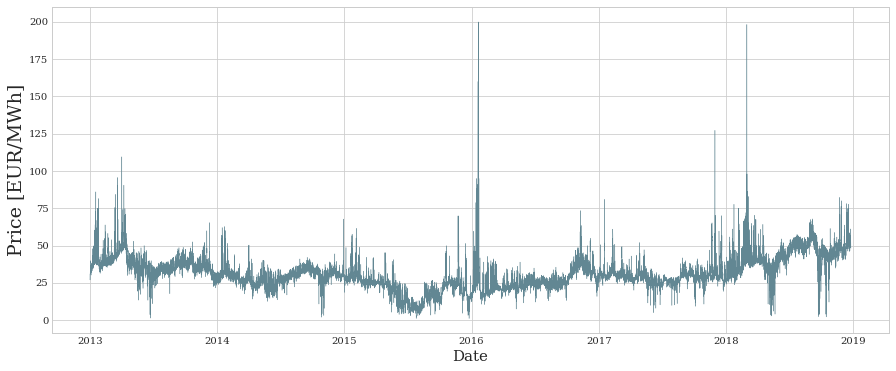

In [ ]:
import pandas as pd
from neuralforecast.data.datasets.epf import EPF
from neuralforecast.data.tsloader import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['NP','FR'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df[Y_df['unique_id']=='NP'].ds, Y_df[Y_df['unique_id']=='NP'].y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=19)
plt.xlabel('Date', fontsize=15)
plt.show()

### Declare Model and Data Parameters

In [ ]:
# Architecture parameters
mc = {}
mc['model'] = 'n-hits'
mc['mode'] = 'simple'
mc['activation'] = 'SELU'

mc['n_time_in'] = 24*3
mc['n_time_out'] = 24
mc['n_x_hidden'] = 8
mc['n_s_hidden'] = 0

mc['stack_types'] = ['identity', 'identity', 'identity']
mc['constant_n_blocks'] = 1
mc['constant_n_layers'] = 2
mc['constant_n_mlp_units'] = 256
mc['n_pool_kernel_size'] = [4, 2, 1]
mc['n_freq_downsample'] = [24, 12, 1]
mc['pooling_mode'] = 'max'
mc['interpolation_mode'] = 'linear'
mc['shared_weights'] = False

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.001
mc['batch_size'] = 1
mc['n_windows'] = 32
mc['lr_decay'] = 0.5
mc['lr_decay_step_size'] = 2
mc['max_epochs'] = 1
mc['max_steps'] = None
mc['early_stop_patience'] = 20
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0.0
mc['dropout_prob_exogenous'] = 0.0
mc['weight_decay'] = 0
mc['loss_train'] = 'MAE'
mc['loss_hypar'] = 0.5
mc['loss_valid'] = mc['loss_train']
mc['random_seed'] = 1

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_windows'] = False
mc['frequency'] = 'H'

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_mlp_units'] = len(mc['stack_types']) * [ mc['constant_n_layers'] * [int(mc['constant_n_mlp_units'])] ]
mc['n_blocks'] =  len(mc['stack_types']) * [ mc['constant_n_blocks'] ]
mc['n_layers'] =  len(mc['stack_types']) * [ mc['constant_n_layers'] ]

model                                             n-hits
mode                                              simple
activation                                          SELU
n_time_in                                             72
n_time_out                                            24
n_x_hidden                                             8
n_s_hidden                                             0
stack_types               [identity, identity, identity]
constant_n_blocks                                      1
constant_n_layers                                      2
constant_n_mlp_units                                 256
n_pool_kernel_size                             [4, 2, 1]
n_freq_downsample                            [24, 12, 1]
pooling_mode                                         max
interpolation_mode                                linear
shared_weights                                     False
initialization                              lecun_normal
learning_rate                  

### Instantiate Loaders and Model

In [ ]:
from neuralforecast.experiments.utils import create_datasets

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                     S_df=S_df, Y_df=Y_df, X_df=X_df,
                                                                     f_cols=['Exogenous1', 'Exogenous2'],
                                                                     ds_in_val=294*24,
                                                                     ds_in_test=728*24)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                n_windows=mc['n_windows'],
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              shuffle=False)

test_loader = TimeSeriesLoader(dataset=test_dataset,
                               batch_size=int(mc['batch_size']),
                               shuffle=False)

mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

In [ ]:
model = NHITS(n_time_in=int(mc['n_time_in']),
              n_time_out=int(mc['n_time_out']),
              n_x=mc['n_x'],
              n_s=mc['n_s'],
              n_s_hidden=int(mc['n_s_hidden']),
              n_x_hidden=int(mc['n_x_hidden']),
              shared_weights=mc['shared_weights'],
              initialization=mc['initialization'],
              activation=mc['activation'],
              stack_types=mc['stack_types'],
              n_blocks=mc['n_blocks'],
              n_layers=mc['n_layers'],
              n_mlp_units=mc['n_mlp_units'],
              n_pool_kernel_size=mc['n_pool_kernel_size'],
              n_freq_downsample=mc['n_freq_downsample'],
              pooling_mode=mc['pooling_mode'],
              interpolation_mode=mc['interpolation_mode'],
              batch_normalization = mc['batch_normalization'],
              dropout_prob_theta=mc['dropout_prob_theta'],
              learning_rate=float(mc['learning_rate']),
              lr_decay=float(mc['lr_decay']),
              lr_decay_step_size=float(mc['lr_decay_step_size']),
              weight_decay=mc['weight_decay'],
              loss_train=mc['loss_train'],
              loss_hypar=float(mc['loss_hypar']),
              loss_valid=mc['loss_valid'],
              frequency=mc['frequency'],
              random_seed=int(mc['random_seed']))

### Train Model

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=mc['early_stop_patience'],
                               verbose=False,
                               mode="min")

trainer = pl.Trainer(max_epochs=mc['max_epochs'], 
                     max_steps=mc['max_steps'],
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     log_every_n_steps=500, 
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:49: LightningDeprecationWarning: Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7. Use `max_steps = -1` instead.
  "Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7."
/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: Fals

Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does no

Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-up3bu5e5/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validating: 0it [00:00, ?it/s]

### Make Predictions

In [ ]:
model.return_decomposition = False
outputs = trainer.predict(model, val_loader)

print("outputs[0][0].shape", outputs[0][0].shape)
print("outputs[0][1].shape", outputs[0][1].shape)
print("outputs[0][2].shape", outputs[0][2].shape)

/Users/kingtzolivares/Desktop/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '
/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 2it [00:00, ?it/s]

outputs[0][0].shape torch.Size([7033, 24])
outputs[0][1].shape torch.Size([7033, 24])
outputs[0][2].shape torch.Size([7033, 24])


# Forecast

In [ ]:
Y_forecast_df = Y_df[Y_df['ds']<'2016-12-27']
Y_forecast_df.tail()

,unique_id,ds,y
87355,NP,2016-12-26 19:00:00,27.44
87356,NP,2016-12-26 20:00:00,27.11
87357,NP,2016-12-26 21:00:00,26.82
87358,NP,2016-12-26 22:00:00,26.65
87359,NP,2016-12-26 23:00:00,25.68


In [ ]:
X_forecast_df = X_df[X_df['ds']<'2016-12-28']
X_forecast_df.tail()

,unique_id,ds,Exogenous1,Exogenous2,week_day,day_0,day_1,day_2,day_3,day_4,day_5,day_6
87379,NP,2016-12-27 19:00:00,0.133135,-0.566365,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87380,NP,2016-12-27 20:00:00,0.010193,-0.569435,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87381,NP,2016-12-27 21:00:00,-0.088980,-0.572021,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87382,NP,2016-12-27 22:00:00,-0.221603,-0.576345,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87383,NP,2016-12-27 23:00:00,-0.426087,-0.583618,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0


In [ ]:
model.return_decomposition = False
forecast_df = model.forecast(Y_df=Y_forecast_df, X_df=X_forecast_df, S_df=S_df, batch_size=2)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2011-01-09 2016-12-26 23:00:00
          1           2016-12-27 2016-12-27 23:00:00
NP        0           2013-01-01 2016-12-26 23:00:00
          1           2016-12-27 2016-12-27 23:00:00
INFO:root:
Total data 			87288 time stamps 
Available percentage=100.0, 	87288 time stamps 
Insample  percentage=0.05, 	48 time stamps 
Outsample percentage=99.95, 	87240 time stamps 

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or,

Predicting: 0it [00:00, ?it/s]

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
forecast_df.head()

,unique_id,ds,y
0,FR,2016-12-27 00:00:00,49.371140
1,FR,2016-12-27 01:00:00,43.137184
2,FR,2016-12-27 02:00:00,50.837498
3,FR,2016-12-27 03:00:00,45.940487
4,FR,2016-12-27 04:00:00,46.389229
